# Orientations points test

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.projection import project 
from src.utils import mip_x,  mip_z
from src.fsc import *
import jax

plt.rcParams["figure.figsize"]=8,8

### Some basic objects and the angles

In [3]:
N = 500
nx = 16
ones3 = jnp.ones([nx,nx,nx])
ones2 = jnp.ones([nx,nx])
x_grid = np.array([0.05, nx])
shifts = jnp.zeros([N,3])
ctf_params = None

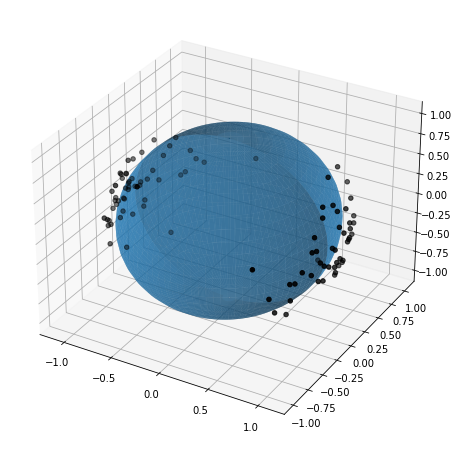

In [4]:
s = 0.3
#angles = jnp.array(np.random.rand(N,3))*jnp.pi*2
#angles_true = s*np.random.randn(int(N),3)
angles = np.concatenate([s*np.random.randn(int(N/2),3), s*np.random.randn(int(N/2),3)+np.pi], axis=0)
np.random.shuffle(angles)
angles = jnp.array(angles)

plot_angles(angles[:100])

### Obtain the points touched by the NN interpolation using the ajoint operator

In [5]:
# For one orientation-shifts pair
def get_nn_points_idx(ang, sh):
    slice_nn = lambda v : project(v, ang, sh, None, x_grid, x_grid, x_grid, "nn")
    jac = jax.jacfwd(slice_nn)(ones3)
    c = jac.reshape(nx*nx, -1).T @ ones2.reshape(nx*nx,1)
    return c.reshape(nx,nx,nx)

In [6]:
# And for the full angles & shifts array
points_adj = jax.vmap(get_nn_points_idx, in_axes = (0,0))(angles, shifts)
points_adj = jnp.real(jnp.sum(points_adj, axis = 0))

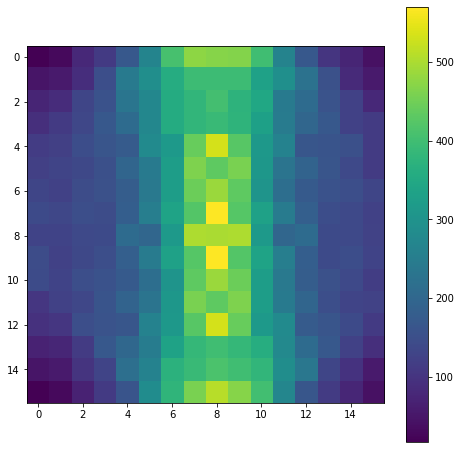

In [7]:
plt.imshow(np.fft.fftshift(points_adj[:,:,0])); plt.colorbar()

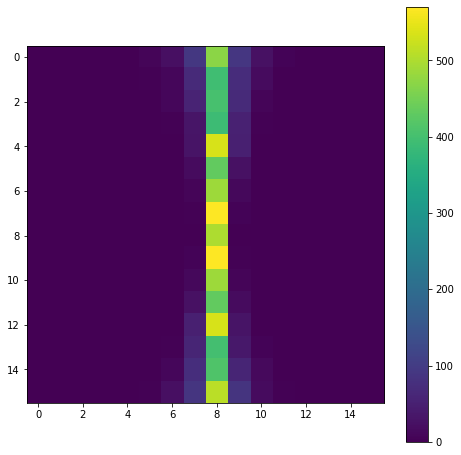

In [8]:
plt.imshow(np.fft.fftshift(points_adj[:,0,:])); plt.colorbar()

### And compare with the points generated by the the function

In [9]:
points_nn = points_orientations_nn(angles, x_grid, x_grid, x_grid)

In [10]:
assert(jnp.sum(jnp.abs(points_nn - points_adj)) == 0)

### Trilinear interpolation

In [11]:
points_tri = points_orientations_tri(angles, x_grid, x_grid, x_grid)

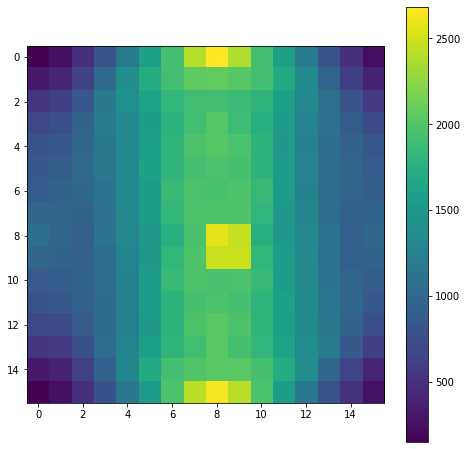

In [12]:
plt.imshow(np.fft.fftshift(points_tri[:,:,0])); plt.colorbar()

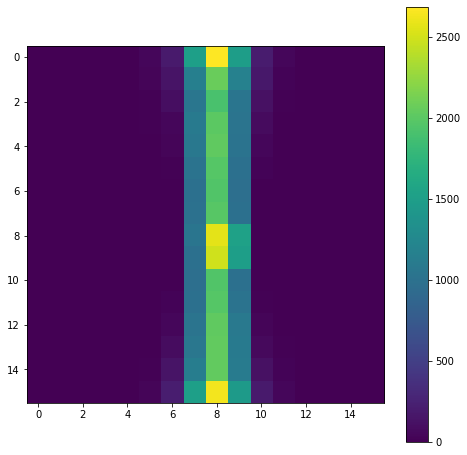

In [13]:
plt.imshow(np.fft.fftshift(points_tri[:,0,:])); plt.colorbar()